# Black Lives Matter: Topic Modeling

### This pipeline is intended to retrieve and model topics for Tweets containing terms related to Ferguson
### but not Michael Brown

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

This version of the pipeline skips some descriptive steps that can be found on the ferguson_mikebrown.ipynb file.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosarodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter
import random

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq

In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, ldamodel
from gensim.test.utils import datapath

In [5]:
# spacy for lemmatization
import spacy

In [6]:
# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [7]:
# Parallelize prediction
import multiprocessing

In [8]:
import pyLDAvis
import pyLDAvis.gensim

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [10]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['url','ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown'])

## Import data

In [12]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-198add732865.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-198add732865.json


In [13]:
%load_ext google.cloud.bigquery

In [14]:
%%bigquery df
SELECT DISTINCT full_text_cleaned AS full_text
FROM tweets.all_valid_tweets
WHERE michael_brown = 0 AND ferguson_ht = 1 AND is_retweet = FALSE

In [15]:
data = list(df['full_text'])

## Pre-processing tweets

### Decompose into bag of words

Let's take a tweet in our data:

In [16]:
tweet = 'News: Ma who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Ma who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'ma', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'shot', 'video', 'ericgarner', 'apparent', 'chokehold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [22]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized =  unique_list_of_lists(remove_stopwords(
    lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
))

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['shoot', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(53, 1), (91, 1), (642, 1), (9129, 1)]


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('shoot', 1), ('arrest', 1), ('charge', 1), ('firearm', 1)]]

### LDA Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

### Choosing the right number of topics

As on the original pipeline file, we would like to optimize the hyper-parameter for number of topics, as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [25]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=num_topics,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
limit = 18
start = 6
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit,
                                                        step=step)

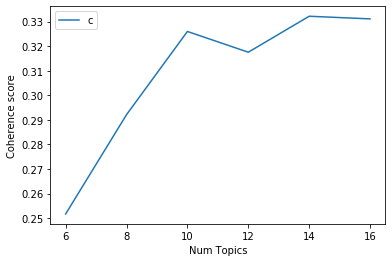

In [28]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of 0.2517
Num Topics = 8  has Coherence Value of 0.2921
Num Topics = 10  has Coherence Value of 0.326
Num Topics = 12  has Coherence Value of 0.3175
Num Topics = 14  has Coherence Value of 0.3322
Num Topics = 16  has Coherence Value of 0.3311


### Working with the optimal model -> Here's the pause

The model that maximized coherence was the one with 10 topics. Coherence rises again after 14 topics, but we'll favor simplicity.

In [30]:
file_name = 'optimal_model_only_ferguson'

In [31]:
#optimal_model = model_list[2]
#optimal_model.save(file_name)

In [32]:
optimal_model = ldamodel.LdaModel.load(file_name, mmap='r')
id2word = corpora.Dictionary.load('optimal_model_only_ferguson.id2word', mmap='r')

In [33]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('loot', 0.009449404987034678),
   ('kid', 0.009343503874467847),
   ('school', 0.009022774790694016),
   ('people', 0.0076309315969585205),
   ('support', 0.006741362251397138),
   ('work', 0.0064055044372566166),
   ('good', 0.00635406675400987),
   ('make', 0.006202779450342968),
   ('time', 0.006196727958196292),
   ('business', 0.006175547735682926)]),
 (1,
  [('police', 0.05615139303064215),
   ('arrest', 0.04710817576702395),
   ('medium', 0.032605390999476035),
   ('journalist', 0.024875316156826723),
   ('reporter', 0.017795343842785156),
   ('protest', 0.01603909671326274),
   ('cop', 0.014205225401219993),
   ('press', 0.014130835559638013),
   ('people', 0.01304733134529177),
   ('protester', 0.011656564741802563)]),
 (2,
  [('people', 0.032722389060586624),
   ('happen', 0.02802459327074465),
   ('thing', 0.020176103562889965),
   ('make', 0.0189296751997201),
   ('shit', 0.01468562306840049),
   ('bad', 0.014465129162050266),
   ('situation', 0.012857892588489125)

## Exploring the results

### Dominant topic in each sentence

In [34]:
def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    words = list(sent_to_words(texts))
    
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 7   # arbitrary default
    
    pool = multiprocessing.Pool(processes=cpus)
    dom_topics_list = pool.map(get_dominant_topic, list(ldamodel[corpus]))
    pool.close()
    
    df_dominant_topic = pd.DataFrame(dom_topics_list)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    df_dominant_topic = pd.concat([df_dominant_topic, contents, bow], axis=1).reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Words']
    
    topic_keywords_dict = get_topic_keywords_dict(ldamodel)
    df_dominant_topic['Topic_Keywords'] = list(map(
        lambda x:topic_keywords_dict[x],
        df_dominant_topic['Dominant_Topic']
    ))
    df_dominant_topic = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text', 'Words']]
    
    return(df_dominant_topic)


def get_dominant_topic(topics):
    topic_num, prop_topic = sorted(topics, key=lambda x: (x[1]), reverse=True)[0]
    prop_topic = round(prop_topic,4)
    return(topic_num + 1, prop_topic)


def get_topic_keywords_dict(ldamodel):
    topic_keywords_dict = {}
    for topic in ldamodel.show_topics(formatted=False, num_topics=20):
        topic_num, topic_keywords = topic
        topic_num += 1
        topic_keywords = ", ".join([word for word, prop in topic_keywords])
        topic_keywords_dict[topic_num] = topic_keywords
    return(topic_keywords_dict)

In [35]:
corpus_ = create_corpus(data)
df_dominant_topic = format_topics_sentences(optimal_model, corpus_, data)

In [36]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,Words
0,0,5,0.7840,"police, officer, shoot, chief, video, release, report, story, lie, call",witnesses an autopsy by a very respected authority in his field and hiding a murderer is all the evidence needed ferguson,"[witnesses, an, autopsy, by, very, respected, authority, in, his, field, and, hiding, murderer, is, all, the, evidence, needed, ferguson]"
1,1,7,0.9173,"black, shoot, police, kill, people, cop, white, man, officer, unarmed",meanwhile white men spit on kick argue with and abuse cops and go home to be with their families everyday ferguson,"[meanwhile, white, men, spit, on, kick, argue, with, and, abuse, cops, and, go, home, to, be, with, their, families, everyday, ferguson]"
2,2,3,0.1341,"people, happen, thing, make, shit, bad, situation, watch, feel, fuck",lrad being used ferguson,"[lrad, being, used, ferguson]"
3,3,10,0.6486,"police, protester, fire, protestor, shoot, cop, people, peaceful, protest, teargas",penning the media up in ferguson is bs many people there report police gassed them before there were any shots but media cant verify,"[penning, the, media, up, in, ferguson, is, bs, many, people, there, report, police, gassed, them, before, there, were, any, shots, but, media, cant, verify]"
4,4,8,0.7448,"police, cop, force, citizen, state, people, military, protect, militarization, local",dise surrender ferguson police diss a must see!!! click here $URL$ ripmikebrown ferguson,"[dise, surrender, ferguson, police, diss, must, see, click, here, url, ripmikebrown, ferguson]"
5,5,4,0.4052,"news, watch, live, twitter, coverage, follow, tweet, read, good, story",police jammers? open garden mesh network may help get info out $URL$ ferguson,"[police, jammers, open, garden, mesh, network, may, help, get, info, out, url, ferguson]"
6,6,1,0.7233,"loot, kid, school, people, support, work, good, make, time, business",americans would be wise to remember that their 1st amendment rights arent worth shit but that money free speech ferguson,"[americans, would, be, wise, to, remember, that, their, st, amendment, rights, arent, worth, shit, but, that, money, free, speech, ferguson]"
7,7,9,0.5877,"people, peace, protest, stand, tonight, justice, love, pray, support, night",why is the browns scrimmage the leading story on wkyc tonight? meanwhile ferguson,"[why, is, the, browns, scrimmage, the, leading, story, on, wkyc, tonight, meanwhile, ferguson]"
8,8,3,0.1341,"people, happen, thing, make, shit, bad, situation, watch, feel, fuck",livestream from ferguson now $URL$,"[livestream, from, ferguson, now, url]"
9,9,3,0.1341,"people, happen, thing, make, shit, bad, situation, watch, feel, fuck",lrad going off ferguson,"[lrad, going, off, ferguson]"


### Most representative tweets

In [37]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
df_dominant_topic_sorted = pd.DataFrame()

df_dominant_topic_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in df_dominant_topic_grpd:
    df_dominant_topic_sorted = pd.concat([df_dominant_topic_sorted, 
                                         grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(10)], 
                                         axis=0)

# Reset Index    
df_dominant_topic_sorted.reset_index(drop=True, inplace=True)

# Format
df_dominant_topic_sorted.columns = ['Document_No','Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Words', 'Topic_Keywords']

# Show
df_dominant_topic_sorted

,Document_No,Topic_Num,Topic_Perc_Contrib,Text,Words,Topic_Keywords
0,671234,1,0.9531,"loot, kid, school, people, support, work, good, make, time, business",idea to stop late night shenanigans in ferguson dance off cops vs rioters stop everything bust out a boom box and circle up losers walk,"[idea, to, stop, late, night, shenanigans, in, ferguson, dance, off, cops, vs, rioters, stop, everything, bust, out, boom, box, and, circle, up, losers, walk]"
1,795426,1,0.9531,"loot, kid, school, people, support, work, good, make, time, business",things not stolen by the ferguson looters pens pencils resume kits work boots gloves coveralls shovels rakes and fathers day cards,"[things, not, stolen, by, the, ferguson, looters, pens, pencils, resume, kits, work, boots, gloves, coveralls, shovels, rakes, and, fathers, day, cards]"
2,921336,1,0.9500,"loot, kid, school, people, support, work, good, make, time, business",hear me out install a giant salad bar in ferguson protestors hungry cops starving they start talking while sharing a healthy meal,"[hear, me, out, install, giant, salad, bar, in, ferguson, protestors, hungry, cops, starving, they, start, talking, while, sharing, healthy, meal]"
3,786404,1,0.9500,"loot, kid, school, people, support, work, good, make, time, business",just visited a 3 part tl part one rioting ferguson photos part two tough guy posing with gun part three posing w toddler gunsense,"[just, visited, part, tl, part, one, rioting, ferguson, photos, part, two, tough, guy, posing, with, gun, part, three, posing, toddler, gunsense]"
4,287720,1,0.9500,"loot, kid, school, people, support, work, good, make, time, business",tmrw teaching blackcodes of miss children apprenticed to former owners if parents poor to pay poor tax students stay fired up ferguson,"[tmrw, teaching, blackcodes, of, miss, children, apprenticed, to, former, owners, if, parents, poor, to, pay, poor, tax, students, stay, fired, up, ferguson]"
5,922811,1,0.9500,"loot, kid, school, people, support, work, good, make, time, business",you dont need stones or bottles ferguson baby oil coco powder mud balloons and small plastic bags chicken feathers and tar optional,"[you, dont, need, stones, or, bottles, ferguson, baby, oil, coco, powder, mud, balloons, and, small, plastic, bags, chicken, feathers, and, tar, optional]"
6,90444,1,0.9464,"loot, kid, school, people, support, work, good, make, time, business",prediction employees working on west florissant wont be happy w short paycheck samsclub schnucks target close early cops ot ferguson,"[prediction, employees, working, on, west, florissant, wont, be, happy, short, paycheck, samsclub, schnucks, target, close, early, cops, ot, ferguson]"
7,153264,1,0.9464,"loot, kid, school, people, support, work, good, make, time, business",tshirts clothes bbq bracelets glowing necklaces and church groups galore! yes the kkk has a huge wooden cross now ferguson protest,"[tshirts, clothes, bbq, bracelets, glowing, necklaces, and, church, groups, galore, yes, the, kkk, has, huge, wooden, cross, now, ferguson, protest]"
8,780491,1,0.9464,"loot, kid, school, people, support, work, good, make, time, business",supported my community in ferguson today folks handing out roses free water devlin scored sour cream and onion chips ferguson,"[supported, my, community, in, ferguson, today, folks, handing, out, roses, free, water, devlin, scored, sour, cream, and, onion, chips, ferguson]"
9,829934,1,0.9464,"loot, kid, school, people, support, work, good, make, time, business",school is out this week no free and reduced lunches for kids local shops closing early parents who need to work have kids at home ferguson,"[school, is, out, this, week, no, free, and, reduced, lunches, for, kids, local, shops, closing, early, parents, who, need, to, work, have, kids, at, home, ferguson]"


### Topic Distribution

In [38]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').set_index('Dominant_Topic')

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
Dominant_Topic,,,
1,"loot, kid, school, people, support, work, good, make, time, business",73265,0.0716
2,"police, arrest, medium, journalist, reporter, protest, cop, press, people, protester",69518,0.0679
3,"people, happen, thing, make, shit, bad, situation, watch, feel, fuck",182198,0.1780
4,"news, watch, live, twitter, coverage, follow, tweet, read, good, story",119731,0.1170
5,"police, officer, shoot, chief, video, release, report, story, lie, call",79386,0.0775
6,"black, people, white, race, racism, issue, vote, community, problem, change",105829,0.1034
7,"black, shoot, police, kill, people, cop, white, man, officer, unarmed",85838,0.0838
8,"police, cop, force, citizen, state, people, military, protect, militarization, local",103420,0.1010
9,"people, peace, protest, stand, tonight, justice, love, pray, support, night",110068,0.1075


## Visualization

### Length

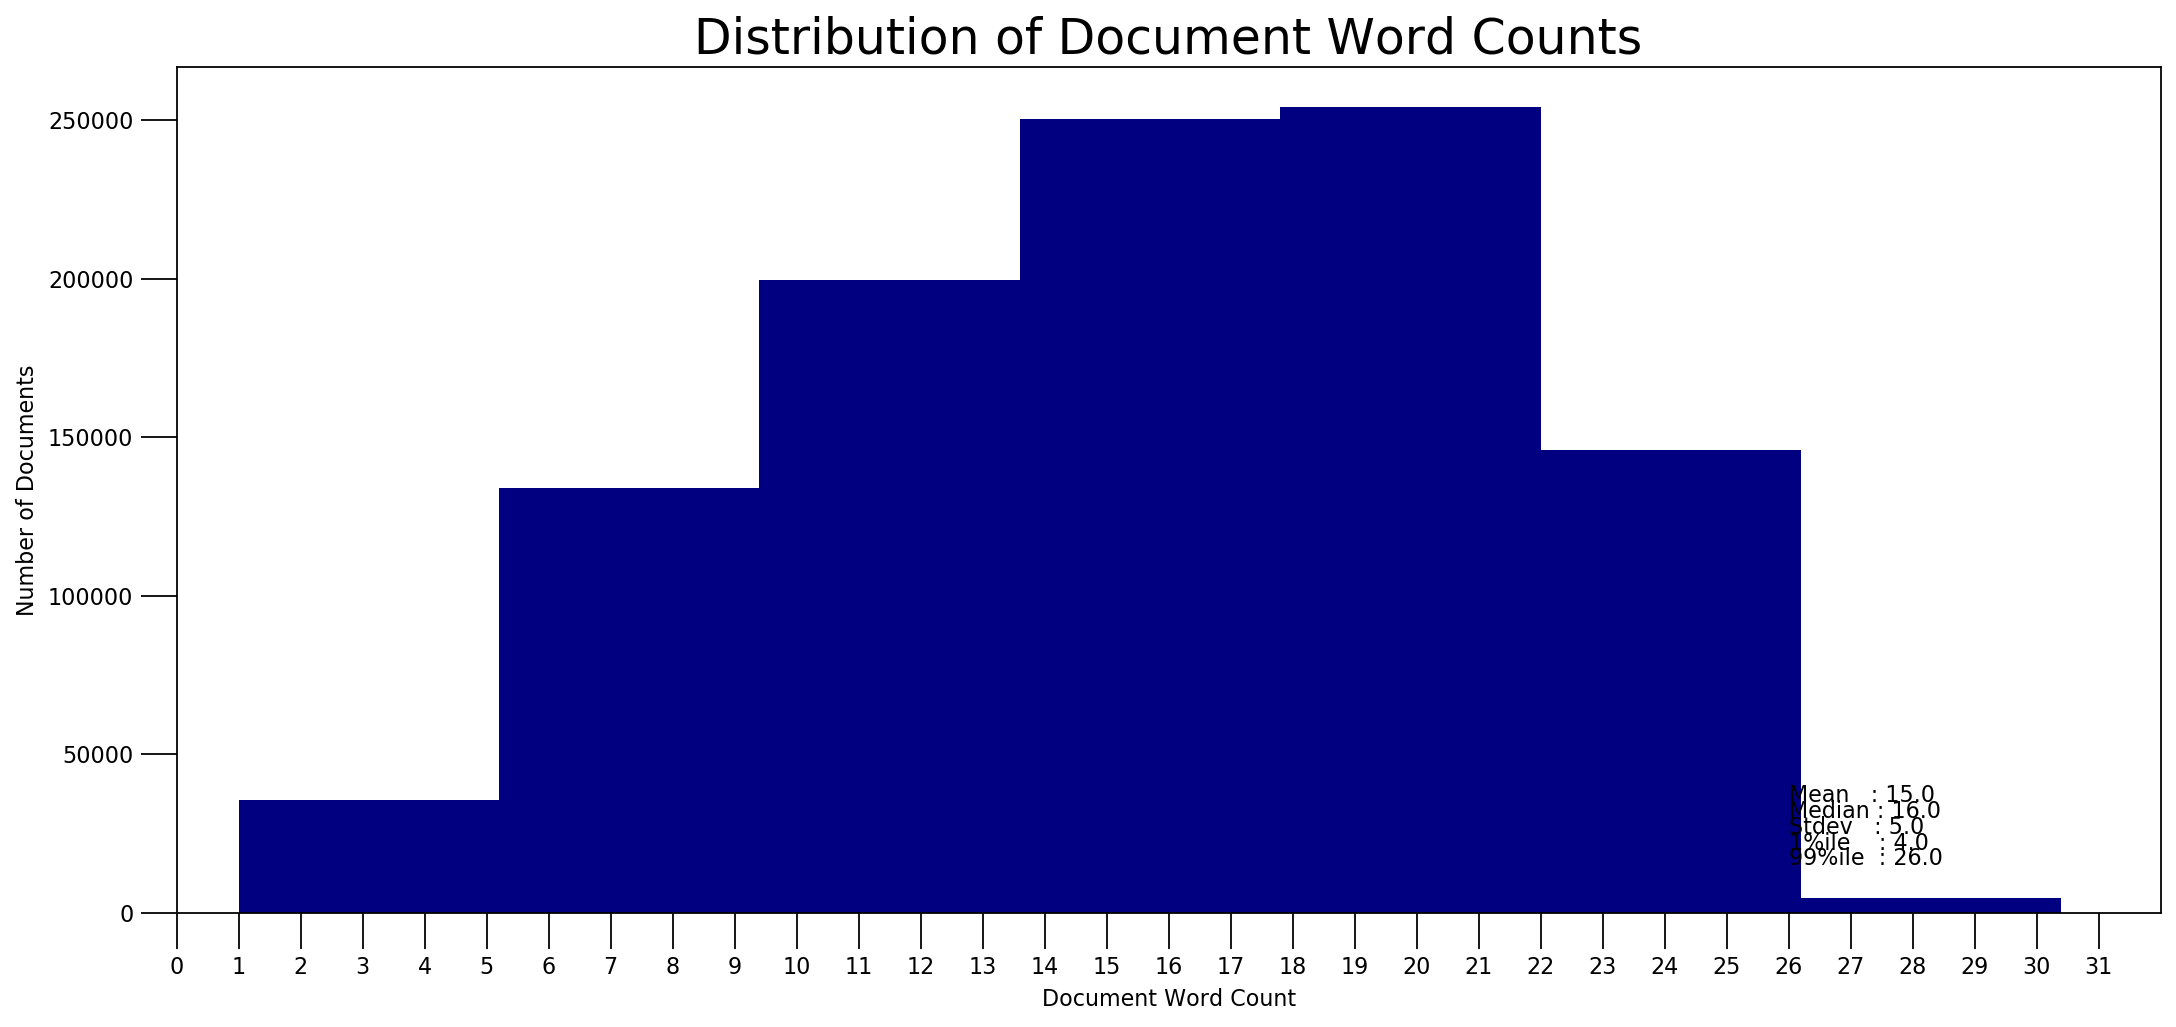

In [54]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 35000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 25000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 20000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 15000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 32), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,32))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

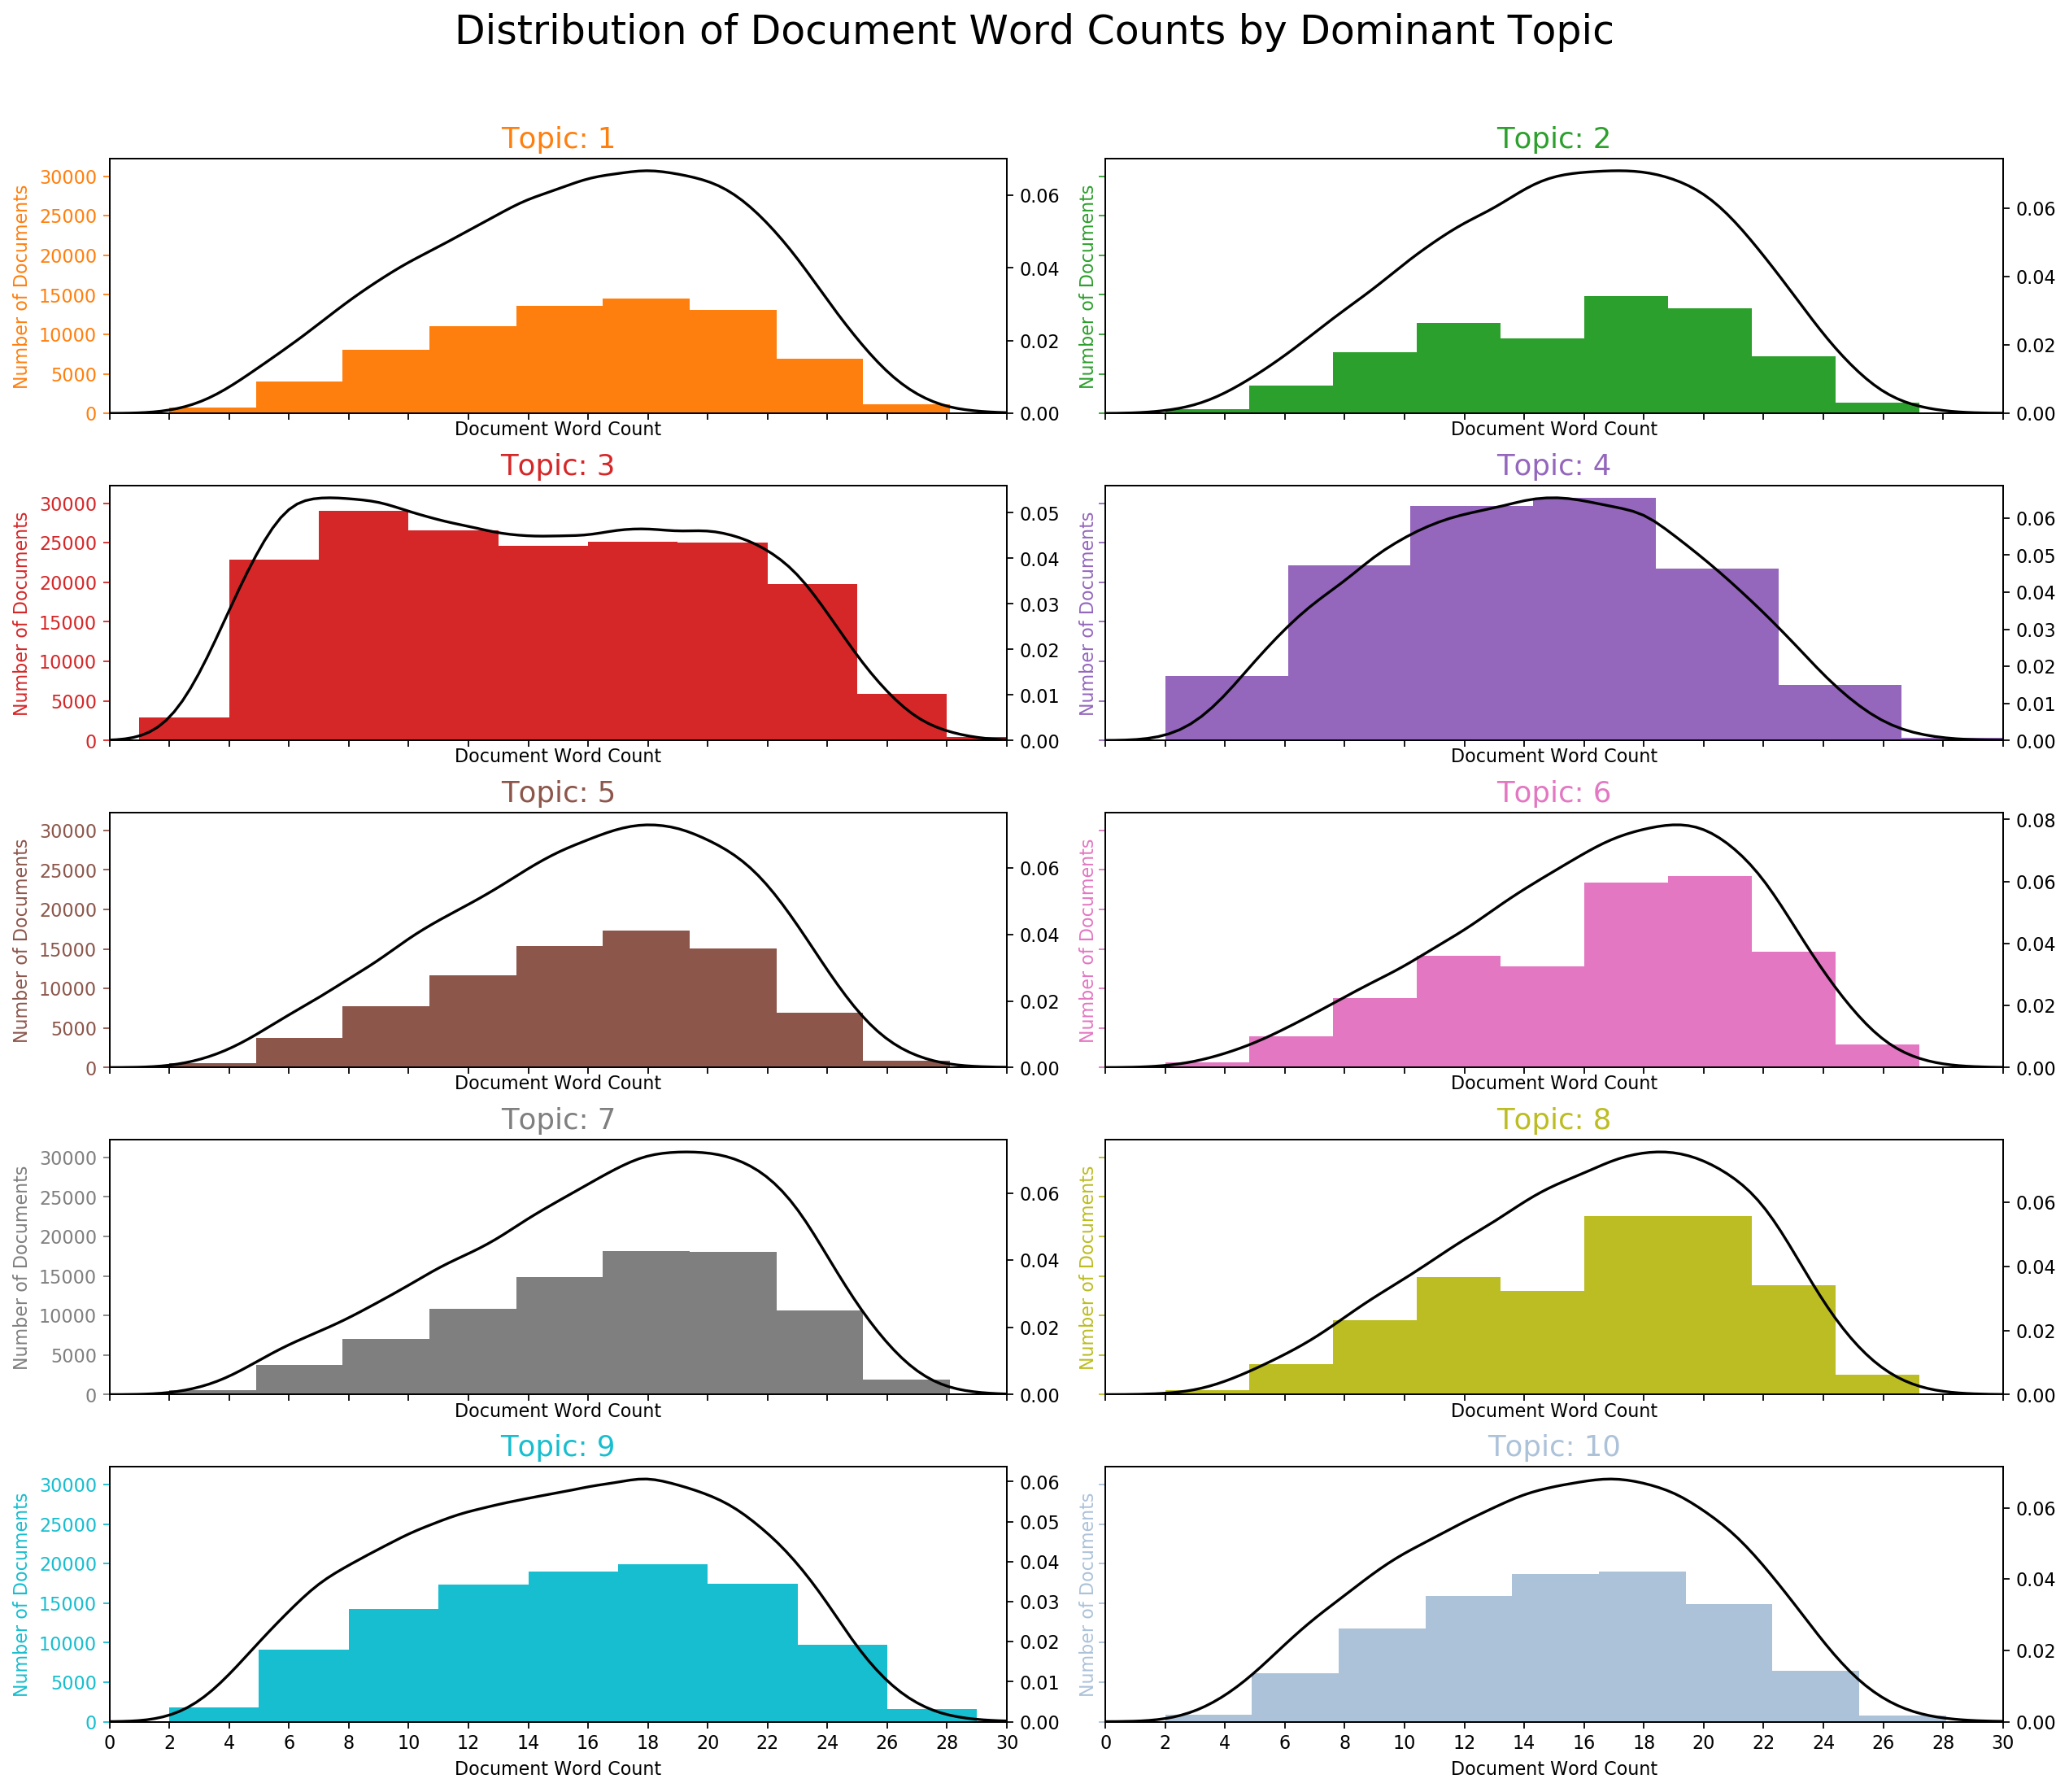

In [40]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    i += 1
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

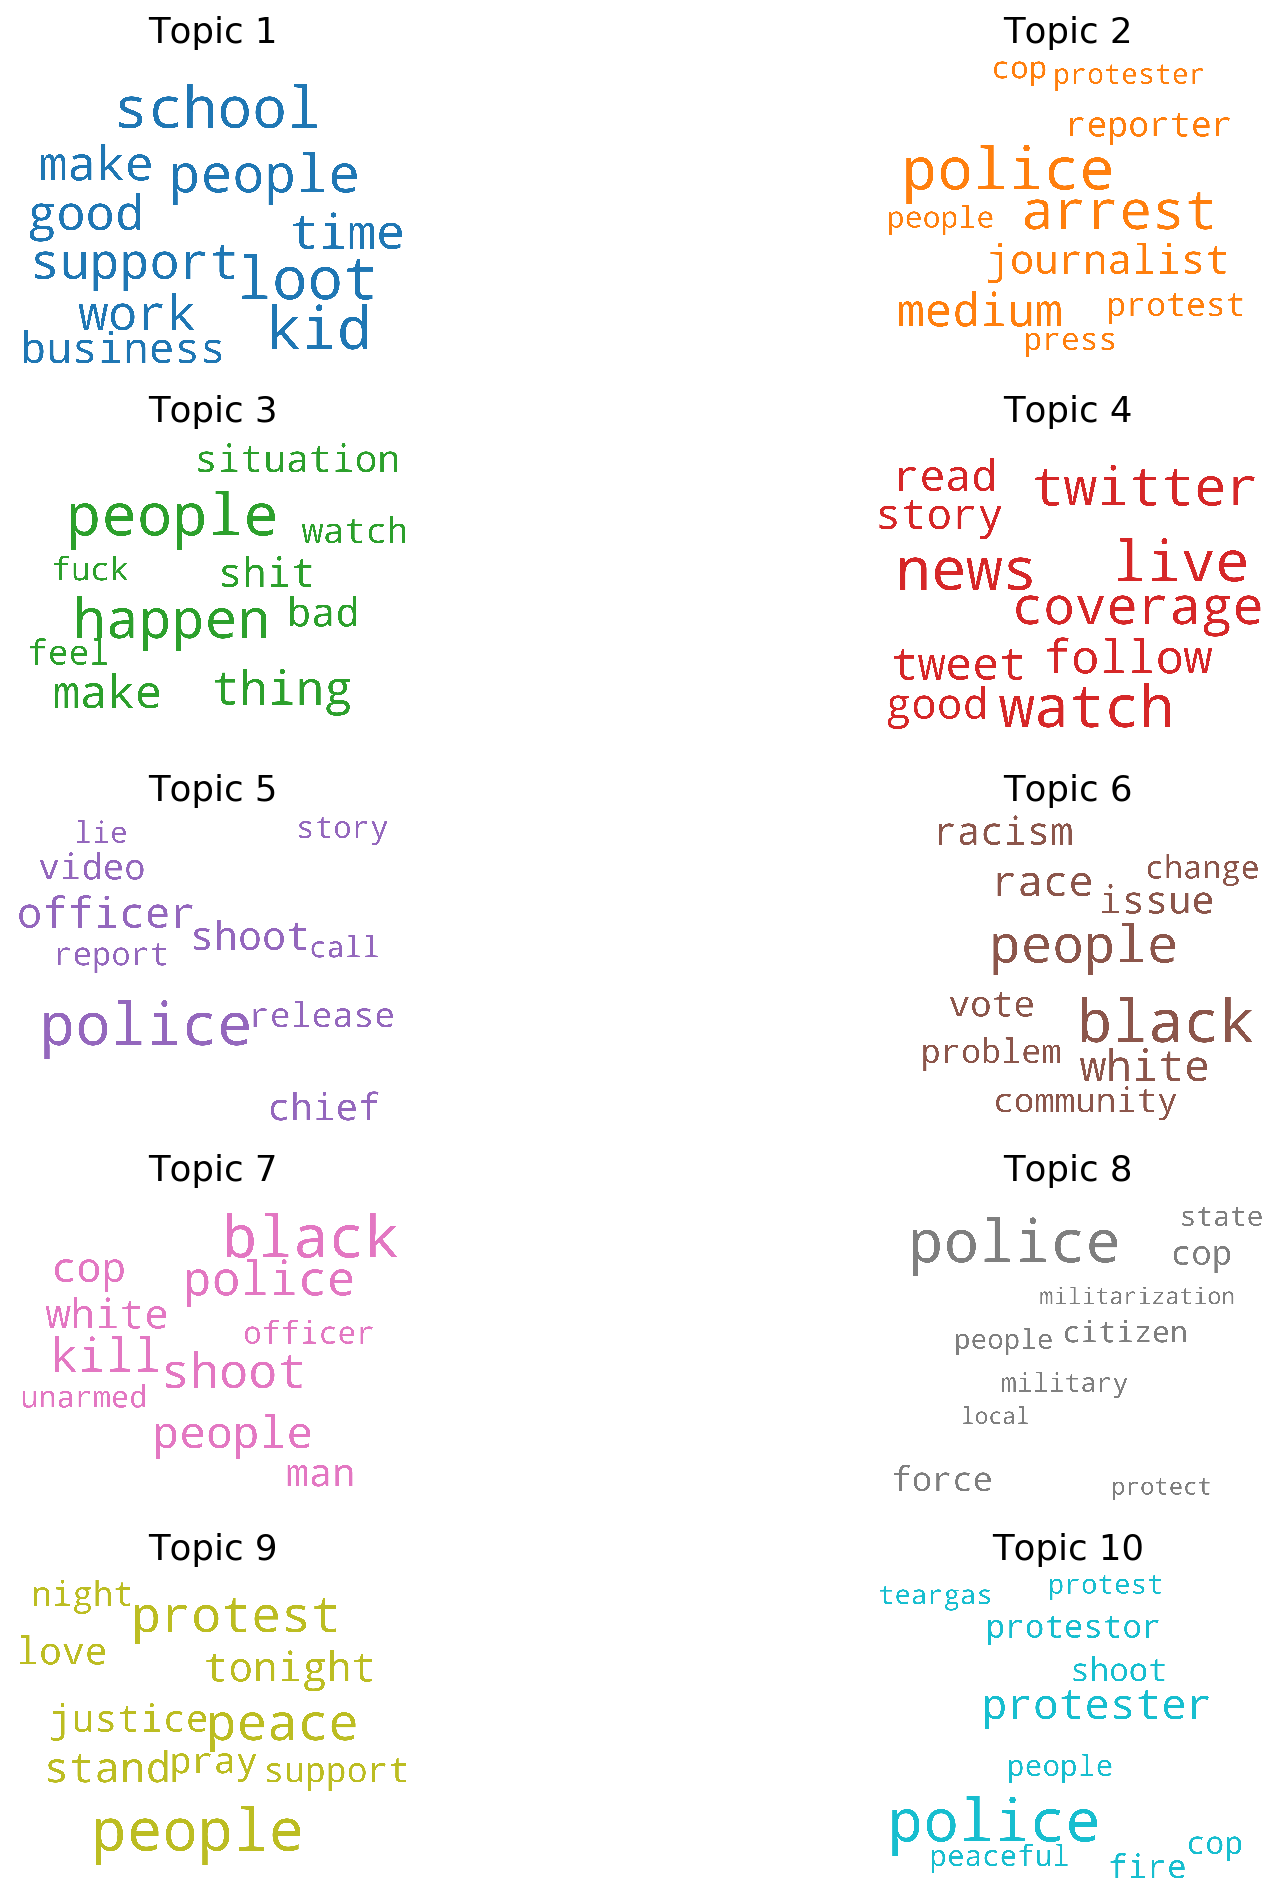

In [57]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2000,
                  height=1600,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(5, 2, figsize=(14,12), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

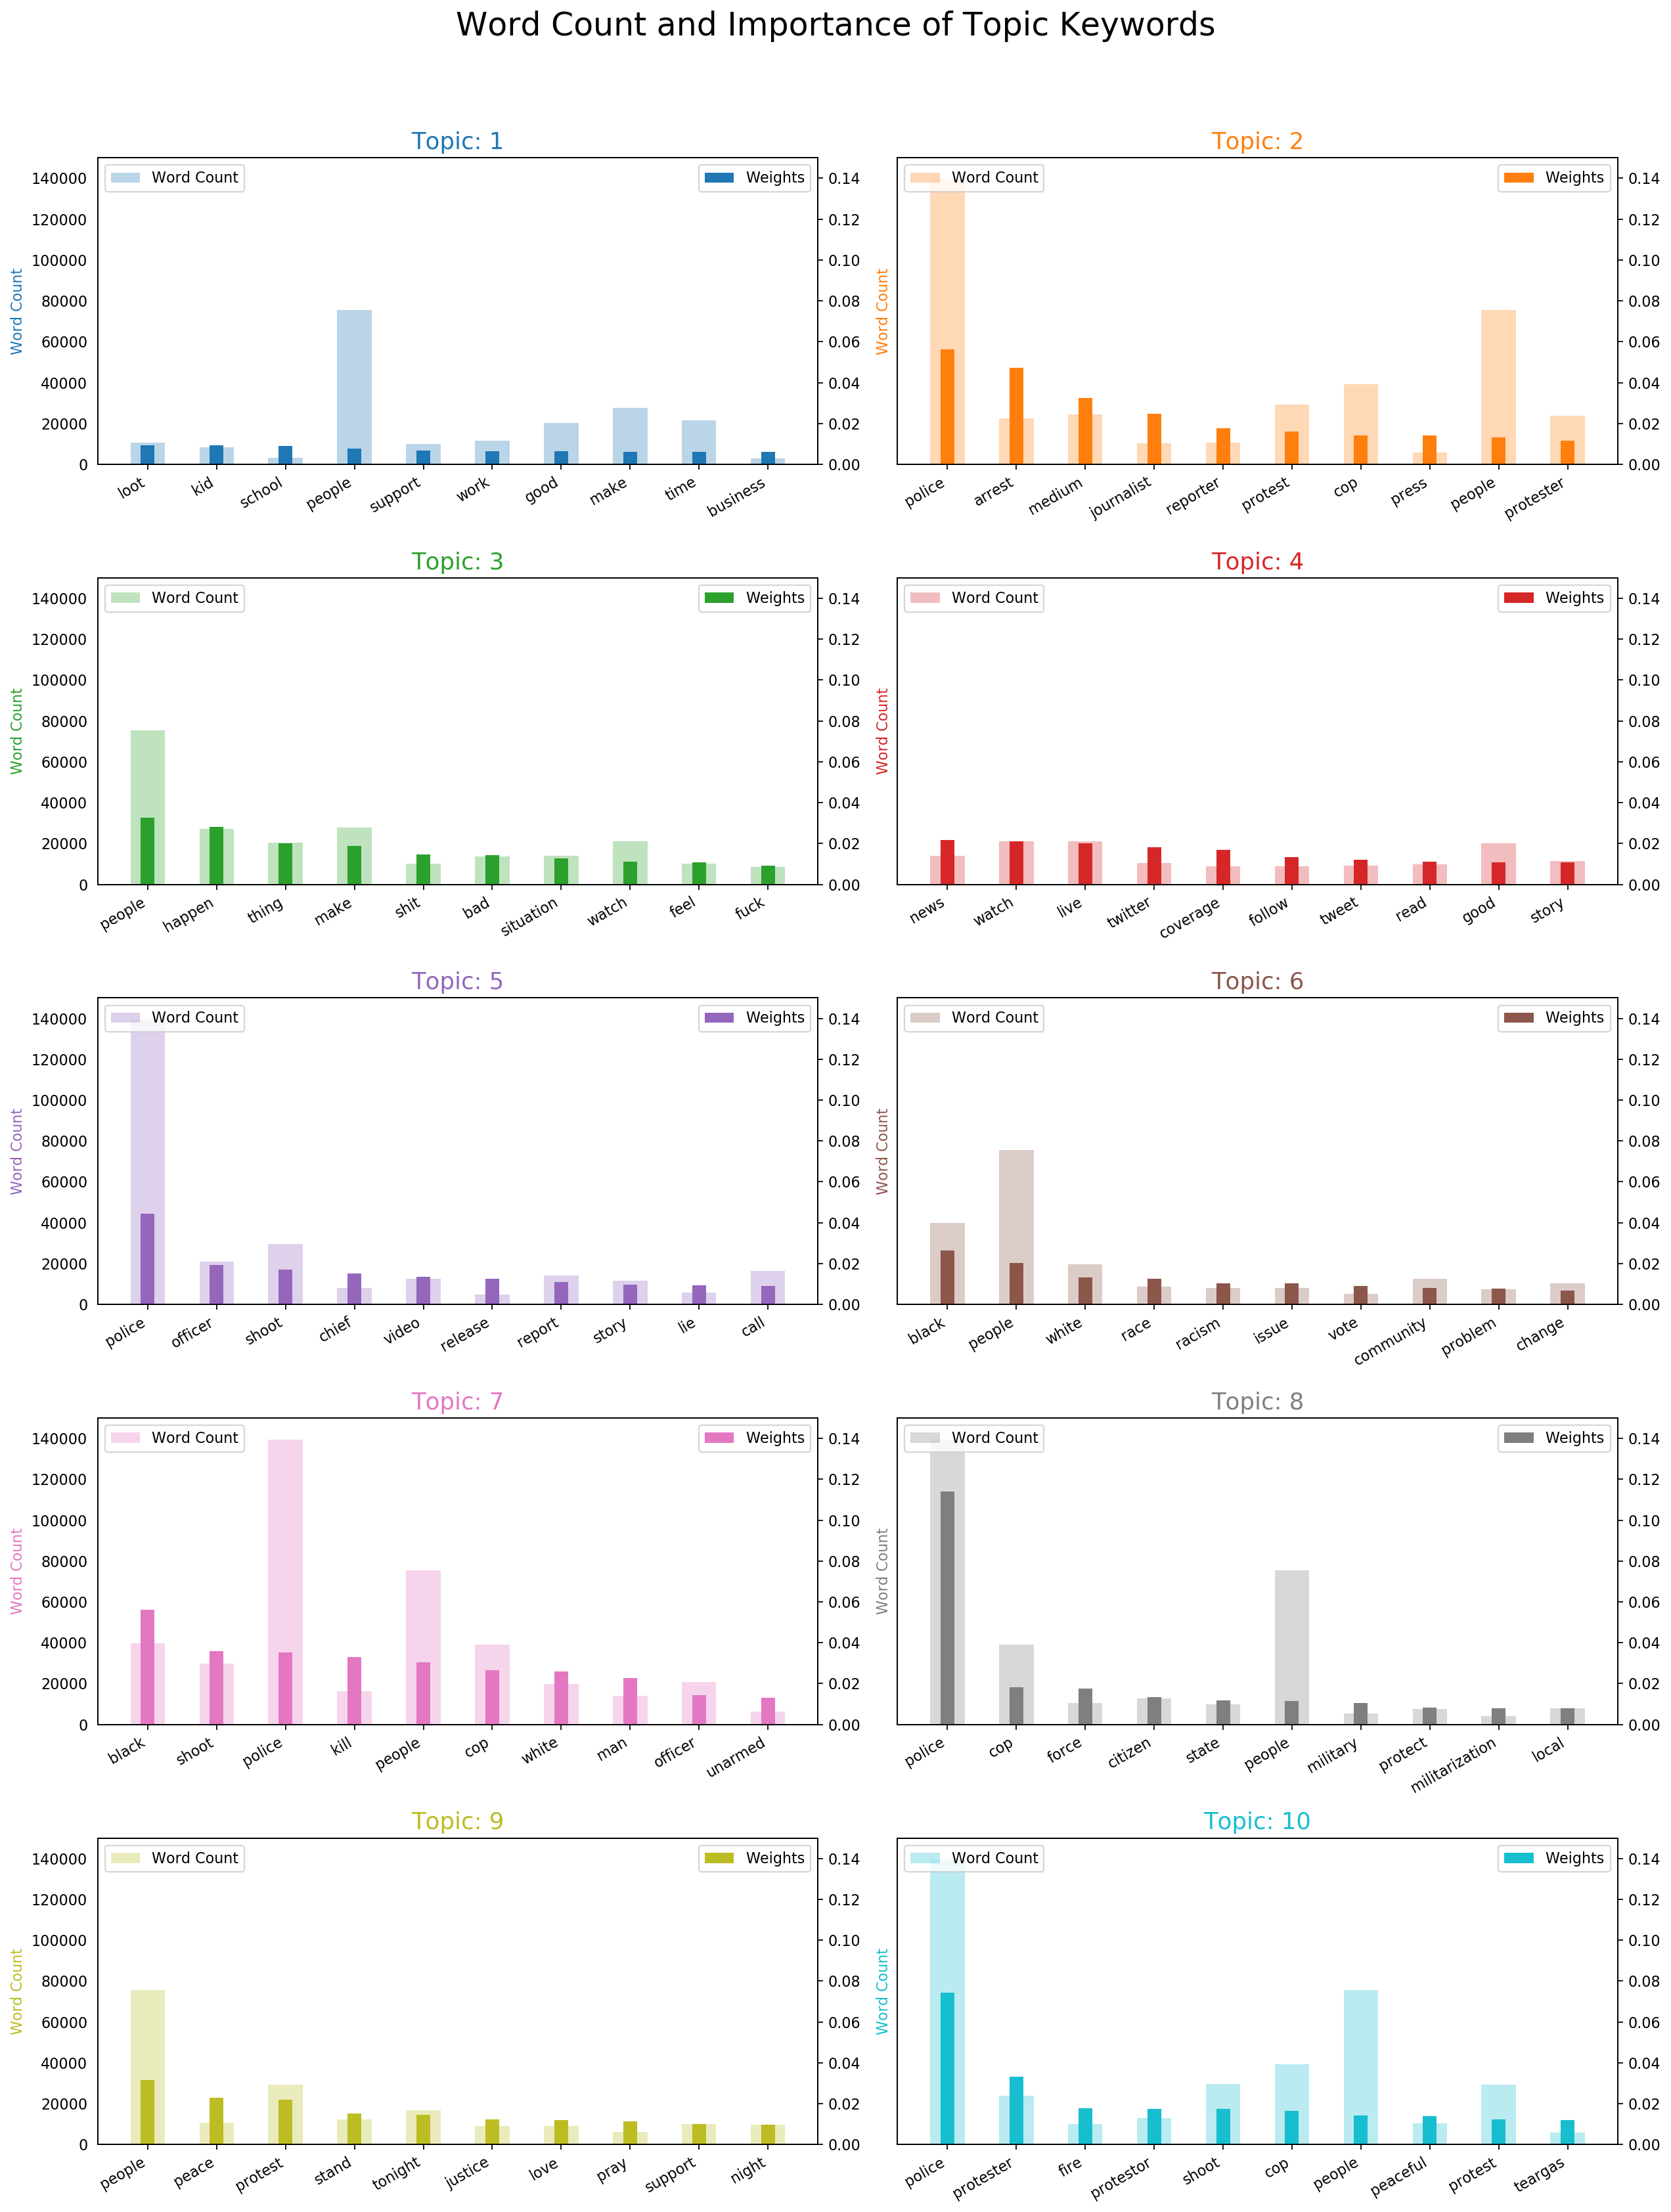

In [61]:
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.15); ax.set_ylim(0, 150000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The terms people, police and cop appear over 40 thousand times and won't let us see the rest of words in detail. Let's trim them.

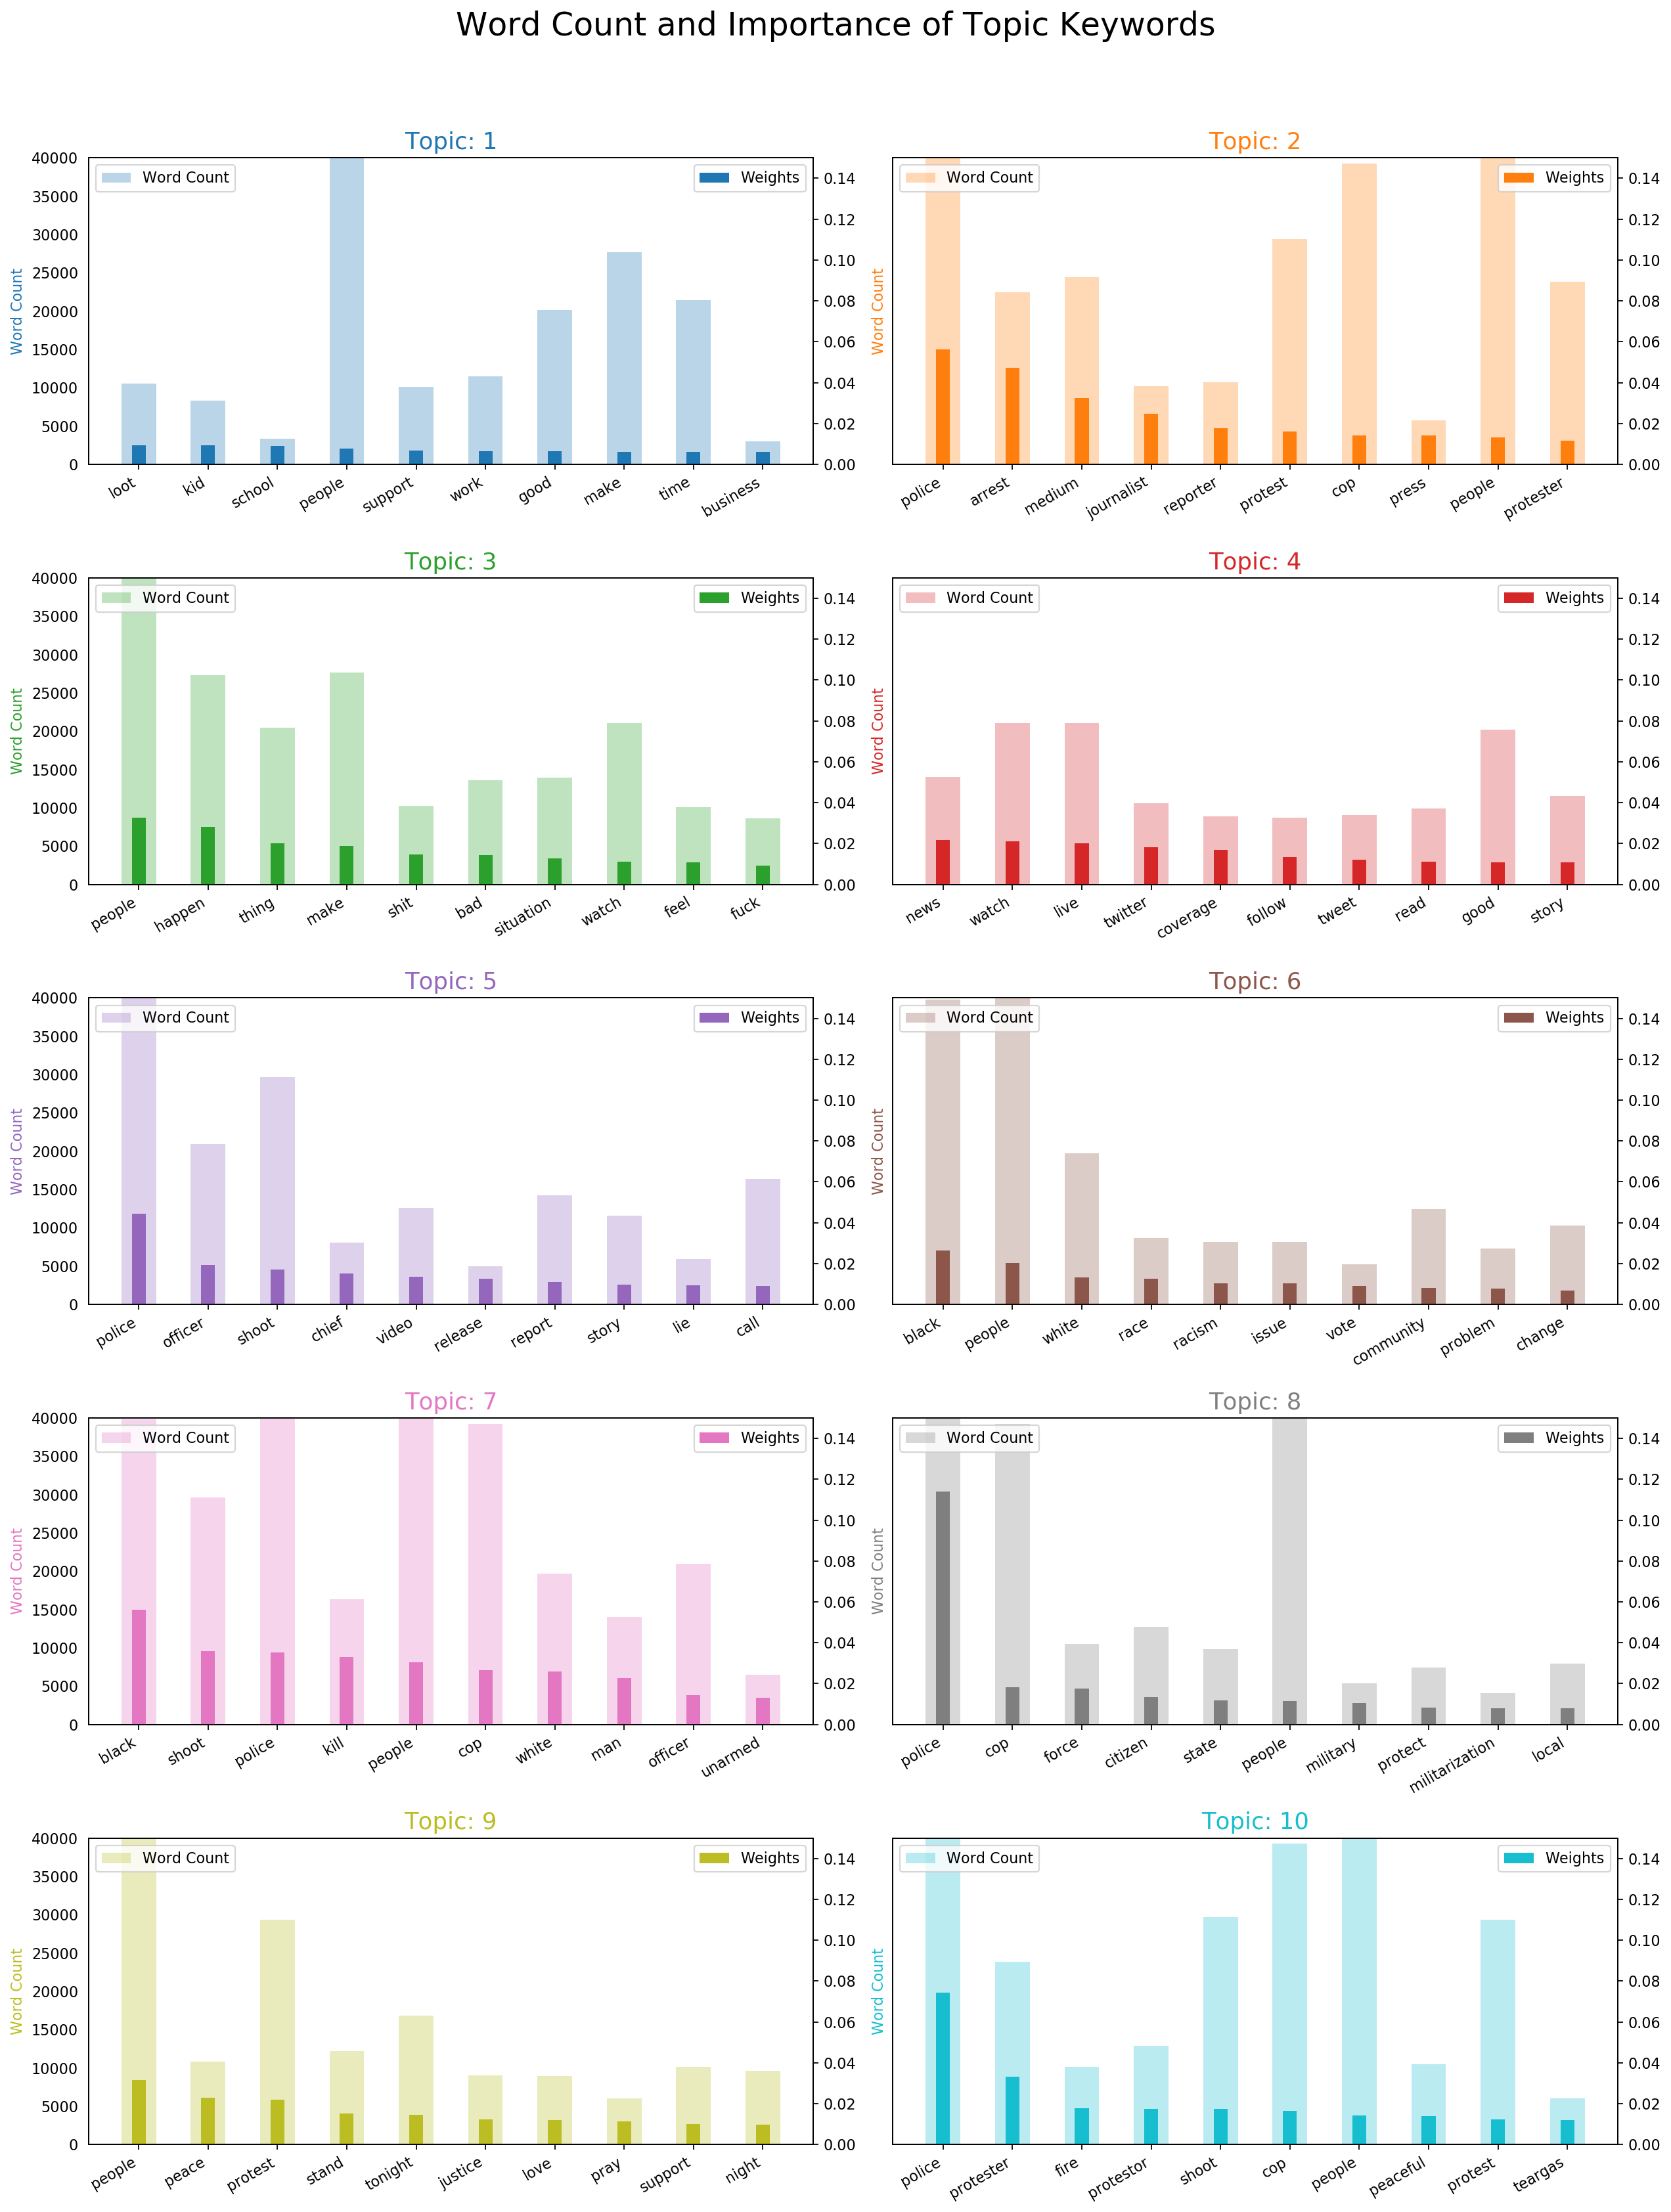

In [62]:
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.15); ax.set_ylim(0, 40000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_, id2word, sort_topics=False, n_jobs=-1)
vis

/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/rosarodriguez/anaconda3/envs/coms007/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([def

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.081851 -0.012730  1       1        7.733883 
1     -0.165353 -0.102116  2       1        7.136956 
2      0.163467  0.014072  3       1        13.102577
3      0.194183 -0.203929  4       1        11.036270
4     -0.086172 -0.034998  5       1        8.296781 
5      0.116334  0.180006  6       1        11.682868
6     -0.110302  0.166907  7       1        9.774622 
7     -0.142424  0.107971  8       1        11.039410
8      0.142010  0.026783  9       1        10.495000
9     -0.193595 -0.141965  10      1        9.701633 , topic_info=      Category           Freq             Term          Total  loglift  \
term                                                                     
23     Default  172692.000000  police           172692.000000  30.0000   
1      Default  48333.000000   black            48333.000000   29.0000   
53     Default  36696.000000   shoot            36696.000000   28.0000   
91     Default  28215.000000   arrest           28215.000000   27.0000   
384    Default  20349.000000   kill             20349.000000   26.0000   
390    Default  23943.000000   white            23943.000000   25.0000   
58     Default  29249.000000   protester        29249.000000   24.0000   
343    Default  30534.000000   medium           30534.000000   23.0000   
165    Default  48906.000000   cop              48906.000000   22.0000   
988    Default  14415.000000   peace            14415.000000   21.0000   
662    Default  12851.000000   journalist       12851.000000   20.0000   
485    Default  26186.000000   officer          26186.000000   19.0000   
111    Default  13548.000000   twitter          13548.000000   18.0000   
15     Default  95451.000000   people           95451.000000   17.0000   
120    Default  26848.000000   watch            26848.000000   16.0000   
145    Default  17907.000000   news             17907.000000   15.0000   
373    Default  17611.000000   man              17611.000000   14.0000   
488    Default  11305.000000   coverage         11305.000000   13.0000   
93     Default  13350.000000   reporter         13350.000000   12.0000   
134    Default  37302.000000   protest          37302.000000   11.0000   
760    Default  13031.000000   force            13031.000000   10.0000   
483    Default  12282.000000   fire             12282.000000   9.0000    
191    Default  17875.000000   report           17875.000000   8.0000    
325    Default  35168.000000   happen           35168.000000   7.0000    
377    Default  13017.000000   peaceful         13017.000000   6.0000    
262    Default  15765.000000   protestor        15765.000000   5.0000    
386    Default  11674.000000   tweet            11674.000000   4.0000    
557    Default  10204.000000   chief            10204.000000   3.0000    
56     Default  26585.000000   live             26585.000000   2.0000    
287    Default  15901.000000   video            15901.000000   1.0000    
3681   Topic1   30.882298      factory          30.882298      2.5596    
42848  Topic1   3.860287       dashboardcams    3.860287       2.5596    
48904  Topic1   7.720575       tub              7.720575       2.5596    
58654  Topic1   3.860287       smuggling        3.860287       2.5596    
25410  Topic1   3.860287       desertstorm      3.860287       2.5596    
34189  Topic1   7.720575       lotto            7.720575       2.5596    
25408  Topic1   16.727912      closingearly     16.727912      2.5596    
34211  Topic1   6.433812       geraldearly      6.433812       2.5596    
34212  Topic1   6.433812       triangle         6.433812       2.5596    
42843  Topic1   14.154387      runwind          14.154387      2.5596    
48866  Topic1   6.433812       classescancele   6.433812       2.5596    
1135   Topic1   15.441149      shaft            15.441149      2.5596    
25341  Topic1   3.860287       squirtbottle     3.860

In [64]:
pyLDAvis.save_html(vis, 'pyLDAvis_only_ferguson.html')

## Upload table with tweet-topic

In [46]:
%%bigquery df_pred
SELECT 
    id,
    REGEXP_REPLACE(full_text_cleaned, "^rt ", "") AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht = 1 AND michael_brown = 0

In [47]:
df_pred

,id,full_text
0,502817915734073340,ferguson naacp says micheal brown star witness being guilty of lying to police ‘doesn’t concern’ $URL$
1,499887725495848960,ferguson doesnt even make it above the cut on the us news section of msnbcs website $URL$
2,501829554168549400,only 4 of the 78 arrested last night were from ferguson mo others from chicago nyc des moines ca dc al tx …
3,501183837041623040,isnt that tat sign of devil ?“ couple dozen people rally to support darren wilson ferguson $URL$
4,501678370925842400,sometimes it takes a cartoon to understand things like ferguson via $URL$
5,500121831475781600,partest rt ferguson ok outside quiktrip weird party protest vibe hard to explain its a partest $URL$
6,498260744975446000,the mother of the boy killed in ferguson speaking to media about the loss of her son $URL$
7,500544796864577540,young men currently stepping up to protect their community ferguson $URL$
8,501940938860949500,twitter i love you but my spirit cant handle any more peace to ferguson and losangeles as we fight for justice
9,504792006443663360,this country is capable of change but change doesnt happen by itself $URL$ ferguson $URL$


In [48]:
data_pred = list(df_pred['full_text'])
ids_pred = list(df_pred['id'])

In [49]:
corpus_pred = create_corpus(data_pred)
df_topic_pred = format_topics_sentences(optimal_model, corpus_pred, data_pred)
df_topic_pred['id'] = ids_pred
df_topic_pred = df_topic_pred[['id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']]

In [50]:
df_topic_pred

,id,Dominant_Topic,Topic_Perc_Contrib,Text
0,502817915734073340,5,0.8730,ferguson naacp says micheal brown star witness being guilty of lying to police ‘doesn’t concern’ $URL$
1,499887725495848960,4,0.8778,ferguson doesnt even make it above the cut on the us news section of msnbcs website $URL$
2,501829554168549400,2,0.7343,only 4 of the 78 arrested last night were from ferguson mo others from chicago nyc des moines ca dc al tx …
3,501183837041623040,9,0.4870,isnt that tat sign of devil ?“ couple dozen people rally to support darren wilson ferguson $URL$
4,501678370925842400,3,0.7522,sometimes it takes a cartoon to understand things like ferguson via $URL$
5,500121831475781600,10,0.6540,partest rt ferguson ok outside quiktrip weird party protest vibe hard to explain its a partest $URL$
6,498260744975446000,7,0.5352,the mother of the boy killed in ferguson speaking to media about the loss of her son $URL$
7,500544796864577540,9,0.8502,young men currently stepping up to protect their community ferguson $URL$
8,501940938860949500,9,0.5295,twitter i love you but my spirit cant handle any more peace to ferguson and losangeles as we fight for justice
9,504792006443663360,3,0.8803,this country is capable of change but change doesnt happen by itself $URL$ ferguson $URL$


In [66]:
# Upload table with topic and contribution
pandas_gbq.to_gbq(df_topic_pred, 'topic_modeling.topics_only_ferguson', project_id='dsi-capstone-f19-group-1')



0it [00:00, ?it/s]

1it [2:12:10, 7930.67s/it][A
